# Comparing Different Augmentation Techniques

Load & clean dataframes

In [21]:
import os

df_train = pd.read_csv("rock-paper-scissors/train/train/_annotations.csv")

def is_image_valid(path):
    try:
        with Image.open(path) as img:
            img.verify()
        return True
    except:
        return False

train_img_dir = "rock-paper-scissors/train/train/"
df_train['full_path'] = df_train['filename'].apply(lambda x: os.path.join(train_img_dir, x))
df_train['is_valid'] = df_train['full_path'].apply(is_image_valid)
df_train_clean = df_train[df_train['is_valid']].reset_index(drop=True)

# Subsample to max 100 per class
def subsample(df, n_per_class=100):
    return df.groupby('class').apply(lambda x: x.sample(min(len(x), n_per_class), random_state=42)).reset_index(drop=True)

train_subset = subsample(df_train_clean, n_per_class=100)

/tmp/ipykernel_1175/400271238.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('class').apply(lambda x: x.sample(min(len(x), n_per_class), random_state=42)).reset_index(drop=True)


In [27]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_subset, test_size=0.2, stratify=train_subset['class'], random_state=42)

In [26]:
from datasets import Dataset, load_dataset

class RockPaperScissorsDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.class_to_idx = {'rock': 0, 'paper': 1, 'scissors': 2}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        path = os.path.join(self.img_dir, row['filename'])
        image = Image.open(path).convert("RGB")
        label = self.class_to_idx[row['class'].lower()]
        if self.transform:
            image = self.transform(image)
        return image, label

ModuleNotFoundError: No module named 'datasets'

Techniques that are going to be used:

1. Baseline (no augmentation)
2. Random Horizontal Flip
3. Random Rotation
4. Random Zoom

In [65]:
# Baseline (no augmentation)
baseline_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Random horizontal flip
hflip_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

# Random rotation
rotation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
])

# Random zoom (using RandomResizedCrop)
zoom_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

# Validation transform (no augmentation)
val_transform = baseline_transform

In [26]:
batch_size = 32
num_workers = 2

train_dataset_baseline = RockPaperScissorsDataset(train_df, train_img_dir, transform=baseline_transform)
train_loader_baseline = DataLoader(train_dataset_baseline, batch_size=batch_size, shuffle=True, num_workers=num_workers)

train_dataset_hflip = RockPaperScissorsDataset(train_df, train_img_dir, transform=hflip_transform)
train_loader_hflip = DataLoader(train_dataset_hflip, batch_size=batch_size, shuffle=True, num_workers=num_workers)

train_dataset_rotation = RockPaperScissorsDataset(train_df, train_img_dir, transform=rotation_transform)
train_loader_rotation = DataLoader(train_dataset_rotation, batch_size=batch_size, shuffle=True, num_workers=num_workers)

train_dataset_zoom = RockPaperScissorsDataset(train_df, train_img_dir, transform=zoom_transform)
train_loader_zoom = DataLoader(train_dataset_zoom, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_dataset = RockPaperScissorsDataset(val_df, train_img_dir, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


NameError: name 'train_df' is not defined

To test the different augmentation techniques I use a simple CNN model 

In [67]:
# --- 6. Simple CNN definition ---
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [68]:
# --- 7. Training and evaluation functions ---
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return accuracy_score(all_labels, all_preds)


In [69]:
# Helper to get probabilities for ROC
def get_probs_and_labels(model, loader):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.numpy())
    return np.concatenate(all_probs), np.concatenate(all_labels)


In [70]:
# --- 8. Train all models and record validation accuracy ---

def train_and_evaluate(train_loader, description):
    model = SimpleCNN(num_classes=3).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    print(f"Training model: {description}")
    for epoch in range(20):
        loss = train_one_epoch(model, train_loader, criterion, optimizer)
        val_acc = evaluate(model, val_loader)
        print(f"Epoch {epoch+1}/20 - Loss: {loss:.4f} - Val Acc: {val_acc:.4f}")
    print(f"Training complete: {description}\n")
    return model

model_baseline = train_and_evaluate(train_loader_baseline, "Baseline (No Augmentation)")
model_hflip = train_and_evaluate(train_loader_hflip, "Random Horizontal Flip")
model_rotation = train_and_evaluate(train_loader_rotation, "Random Rotation")
model_zoom = train_and_evaluate(train_loader_zoom, "Random Zoom")

Training model: Baseline (No Augmentation)
Epoch 1/20 - Loss: 1.1084 - Val Acc: 0.3167
Epoch 2/20 - Loss: 1.0959 - Val Acc: 0.4500
Epoch 3/20 - Loss: 1.0641 - Val Acc: 0.3667
Epoch 4/20 - Loss: 1.0208 - Val Acc: 0.4833
Epoch 5/20 - Loss: 0.9481 - Val Acc: 0.4000
Epoch 6/20 - Loss: 0.9242 - Val Acc: 0.4167
Epoch 7/20 - Loss: 0.7889 - Val Acc: 0.3167
Epoch 8/20 - Loss: 0.6974 - Val Acc: 0.3833
Epoch 9/20 - Loss: 0.5815 - Val Acc: 0.3667
Epoch 10/20 - Loss: 0.4797 - Val Acc: 0.3333
Epoch 11/20 - Loss: 0.3555 - Val Acc: 0.3833
Epoch 12/20 - Loss: 0.2945 - Val Acc: 0.3333
Epoch 13/20 - Loss: 0.2477 - Val Acc: 0.4000
Epoch 14/20 - Loss: 0.2018 - Val Acc: 0.4000
Epoch 15/20 - Loss: 0.1251 - Val Acc: 0.4167
Epoch 16/20 - Loss: 0.0787 - Val Acc: 0.4000
Epoch 17/20 - Loss: 0.0386 - Val Acc: 0.4167
Epoch 18/20 - Loss: 0.0366 - Val Acc: 0.3333
Epoch 19/20 - Loss: 0.2029 - Val Acc: 0.3667
Epoch 20/20 - Loss: 0.1227 - Val Acc: 0.3833
Training complete: Baseline (No Augmentation)

Training model: Ran

Visualizing 

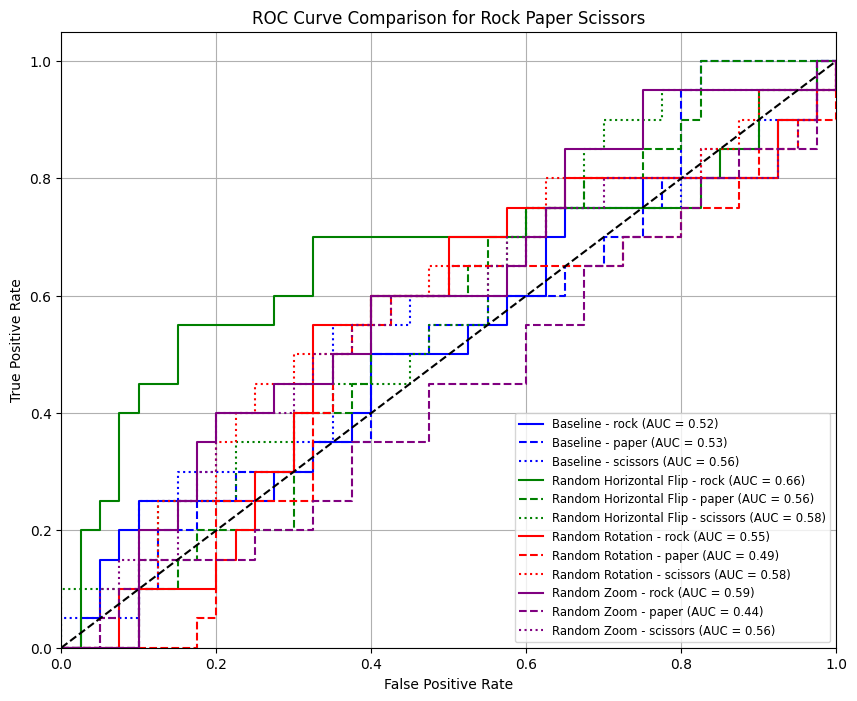

In [71]:
# --- 9. Plot ROC curves for all models ---

def plot_roc_curves_multi(models_info, val_loader, device):
    class_names = ['rock', 'paper', 'scissors']
    n_classes = len(class_names)

    plt.figure(figsize=(10, 8))
    colors = ['blue', 'green', 'red', 'purple', 'orange']  # Colors for different models

    # Get true labels from val_loader once
    true_labels = []
    for _, labels in val_loader:
        true_labels.append(labels.numpy())
    true_labels = np.concatenate(true_labels)
    true_bin = label_binarize(true_labels, classes=range(n_classes))

    for idx, (name, model) in enumerate(models_info):
        probs, _ = get_probs_and_labels(model, val_loader)
        for class_idx in range(n_classes):
            fpr, tpr, _ = roc_curve(true_bin[:, class_idx], probs[:, class_idx])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr,
                     color=colors[idx % len(colors)],
                     linestyle=['-', '--', ':'][class_idx % 3],
                     label=f'{name} - {class_names[class_idx]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison for Rock Paper Scissors')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.show()

models_to_compare = [
    ("Baseline", model_baseline),
    ("Random Horizontal Flip", model_hflip),
    ("Random Rotation", model_rotation),
    ("Random Zoom", model_zoom),
]

plot_roc_curves_multi(models_to_compare, val_loader, device)

Based on this graph, we can see that the Random Horizontal flip is the augmentation we want to use.